In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
from xml.etree import ElementTree
from xml.dom import minidom
import collections
%matplotlib inline

In [ ]:
base_path = '/content/drive/MyDrive/ss-dataset/'

damageTypes=["D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44"]

In [ ]:
cls_names = []
total_images = 0
file_list = [filename for filename in os.listdir(base_path + 'annotations/') if not filename.startswith('.')]

for file in file_list:
        total_images = total_images + 1
        if file =='.DS_Store':
            pass
        else:
            infile_xml = open(base_path +'/annotations/' +file)
            tree = ElementTree.parse(infile_xml)
            root = tree.getroot()
            for obj in root.iter('object'):
                cls_name = obj.find('name').text
                cls_names.append(cls_name)

print("total")
print("# of images：" + str(total_images))
print("# of labels：" + str(len(cls_names)))

total
# of images：780
# of labels：843


D00 : 151
D01 : 16
D10 : 5
D11 : 6
D20 : 216
D40 : 336
D43 : 10
D44 : 98


<Axes: >

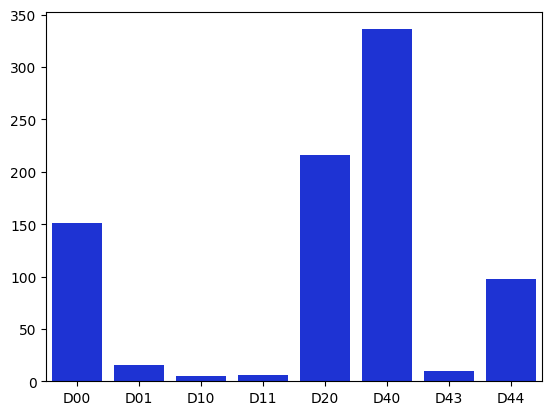

In [ ]:
count_dict = collections.Counter(cls_names)
cls_count = []
for damageType in damageTypes:
    print(str(damageType) + ' : ' + str(count_dict[damageType]))
    cls_count.append(count_dict[damageType])

sns.set_palette("winter", 8)
sns.barplot(x=damageTypes, y=cls_count)

In [ ]:
def draw_images(image_file):
    gov = image_file.split('_')[0]
    img = cv2.imread(base_path + '/images/' + image_file.split('.')[0] + '.jpg')

    infile_xml = open(base_path + '/annotations/' +image_file)
    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()

    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymin = int(xmlbox.find('ymin').text)
        ymax = int(xmlbox.find('ymax').text)

        font = cv2.FONT_HERSHEY_SIMPLEX

        # put text
        cv2.putText(img,cls_name,(xmin,ymin-10),font,1,(0,255,0),2,cv2.LINE_AA)

        # draw bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0),3)
    return img

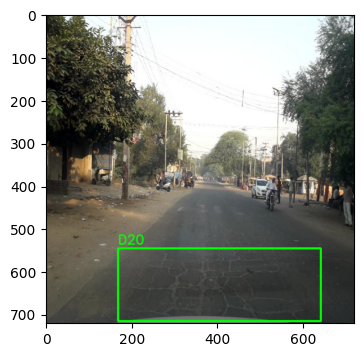

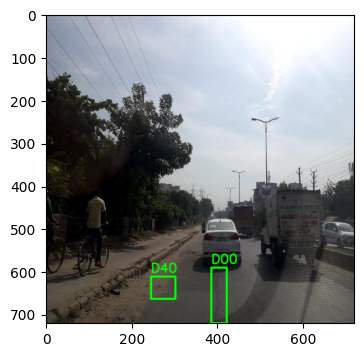

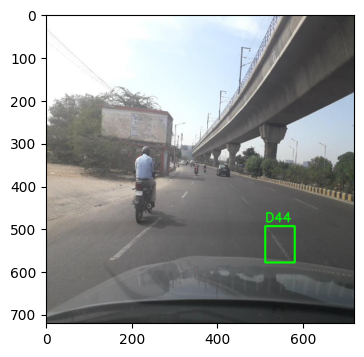

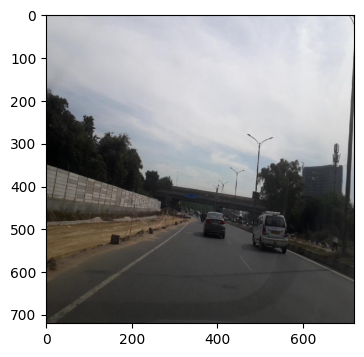

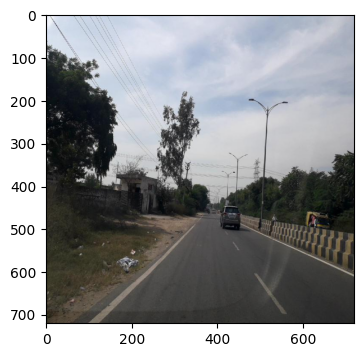

In [ ]:
import matplotlib.pyplot as plt
import random

random_image_files = random.sample(file_list, 5)

for image_file in random_image_files:
    img = draw_images(image_file)
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
def parse_annotation(annotation_path):
    tree = ElementTree.parse(annotation_path)
    root = tree.getroot()

    image_info = {
        'filename': root.find('filename').text,
        'objects': []
    }

    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymin = int(xmlbox.find('ymin').text)
        ymax = int(xmlbox.find('ymax').text)

        image_info['objects'].append({
            'class': cls_name,
            'bbox': [xmin, ymin, xmax, ymax]
        })

    return image_info

# Load dataset for both classification and object detection
def load_dataset(base_path):
    annotations_dir = os.path.join(base_path, 'annotations/')
    images_dir = os.path.join(base_path, 'images/')

    file_list = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]

    data = []
    for xml_file in file_list:
        annotation_path = os.path.join(annotations_dir, xml_file)
        image_info = parse_annotation(annotation_path)

        image_path = os.path.join(images_dir, image_info['filename'])
        if os.path.exists(image_path) and image_info['objects']:
            # For classification, get the dominant class
            classes = [obj['class'] for obj in image_info['objects']]
            dominant_class = max(set(classes), key=classes.count)

            # Store both classification and object detection data
            data.append({
                'image_path': image_path,
                'classification_label': dominant_class,
                'detection_objects': image_info['objects']  # Full object data including bboxes
            })

    return pd.DataFrame(data)

In [ ]:
df = load_dataset(base_path)
df.head()

,image_path,classification_label,detection_objects
0,/content/drive/MyDrive/ss-dataset/images/India...,D40,"[{'class': 'D40', 'bbox': [295, 634, 342, 663]}]"
1,/content/drive/MyDrive/ss-dataset/images/India...,D20,"[{'class': 'D20', 'bbox': [231, 568, 397, 716]..."
2,/content/drive/MyDrive/ss-dataset/images/India...,D00,"[{'class': 'D00', 'bbox': [408, 372, 438, 553]}]"
3,/content/drive/MyDrive/ss-dataset/images/India...,D40,"[{'class': 'D40', 'bbox': [516, 512, 620, 558]..."
4,/content/drive/MyDrive/ss-dataset/images/India...,D44,"[{'class': 'D44', 'bbox': [554, 596, 631, 660]}]"


In [ ]:
def balance_dataset(df):
    max_count = df['classification_label'].value_counts().max()
    balanced_dfs = []

    for label in df['classification_label'].unique():
        label_df = df[df['classification_label'] == label]
        if len(label_df) < max_count:
            # Oversample minority class
            oversample_factor = max_count // len(label_df)
            remainder = max_count % len(label_df)

            label_df_oversampled = pd.concat([label_df] * oversample_factor, ignore_index=True)
            if remainder > 0:
                label_df_oversampled = pd.concat([label_df_oversampled, label_df.sample(remainder)], ignore_index=True)
        else:
            label_df_oversampled = label_df

        balanced_dfs.append(label_df_oversampled)

    return pd.concat(balanced_dfs, ignore_index=True).sample(frac=1).reset_index(drop=True)

# Balance the dataset
df = balance_dataset(df)

# Encode the classification labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['classification_label'])
num_classes = len(label_encoder.classes_)

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Number of classes: {num_classes}")

Train samples: 907
Validation samples: 101
Test samples: 252
Number of classes: 9


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

In [ ]:
from huggingface_hub import login
import os

# Set your Hugging Face token
HF_TOKEN = os.getenv("HF_TOKEN")

# Login to Hugging Face Hub
login(token=HF_TOKEN)

In [ ]:
class DamageDataset(Dataset):
    def __init__(self, dataframe, feature_extractor, is_training=True):
        self.dataframe = dataframe
        self.feature_extractor = feature_extractor
        self.is_training = is_training

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['image_path']
        label = row['label_encoded']
        objects = row['detection_objects']

        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')

        # Get the boundary box information
        boxes = []
        classes = []

        for obj in objects:
            xmin, ymin, xmax, ymax = obj['bbox']
            boxes.append([xmin, ymin, xmax, ymax])
            classes.append(obj['class'])

        # Normalize boxes to 0-1 range
        orig_width, orig_height = image.size
        normalized_boxes = []
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            normalized_boxes.append([
                xmin / orig_width,
                ymin / orig_height,
                xmax / orig_width,
                ymax / orig_height
            ])

        # Process inputs for ViT
        inputs = self.feature_extractor(images=image, return_tensors="pt")

        # Remove batch dimension
        for k, v in inputs.items():
            inputs[k] = v.squeeze()

        # Add labels and boxes
        inputs["labels"] = label
        inputs["normalized_boxes"] = normalized_boxes
        inputs["original_size"] = (orig_width, orig_height)

        return inputs

class DamageViTModel(nn.Module):
    def __init__(self, num_classes, pretrained_model_name="google/vit-base-patch16-224-in21k"):
        super(DamageViTModel, self).__init__()
        # Load pretrained ViT
        self.vit = ViTForImageClassification.from_pretrained(
            pretrained_model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

        # Freeze base model layers
        for param in self.vit.vit.parameters():
            param.requires_grad = False

        # Unfreeze the final layers
        for param in self.vit.classifier.parameters():
            param.requires_grad = True

        # Bbox regression head using the ViT's hidden representation
        self.bbox_regressor = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 4)  # 4 outputs for [x_min, y_min, x_max, y_max]
        )

    def forward(self, pixel_values, labels=None):
        # Forward pass through ViT
        outputs = self.vit(
            pixel_values=pixel_values,
            labels=labels,
            output_hidden_states=True
        )

        # Get classification logits
        class_logits = outputs.logits

        # Extract hidden state from the [CLS] token
        cls_token = outputs.hidden_states[-1][:, 0]

        # Bbox prediction
        bbox_pred = self.bbox_regressor(cls_token)
        # Apply sigmoid to ensure predictions are between 0 and 1
        bbox_pred = torch.sigmoid(bbox_pred)

        return {
            'class_logits': class_logits,
            'bbox_pred': bbox_pred,
            'loss': outputs.loss if labels is not None else None
        }

In [ ]:
class DamageViTModel(nn.Module):
    def __init__(self, num_classes, pretrained_model_name="google/vit-base-patch16-224-in21k"):
        super(DamageViTModel, self).__init__()
        # Load pretrained ViT
        self.vit = ViTForImageClassification.from_pretrained(
            pretrained_model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

        # Freeze base model layers
        for param in self.vit.vit.parameters():
            param.requires_grad = False

        # Unfreeze the final layers
        for param in self.vit.classifier.parameters():
            param.requires_grad = True

        # Bbox regression head using the ViT's hidden representation
        self.bbox_regressor = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 4)  # 4 outputs for [x_min, y_min, x_max, y_max]
        )

    def forward(self, pixel_values, labels=None):
        # Forward pass through ViT
        outputs = self.vit(
            pixel_values=pixel_values,
            labels=labels,
            output_hidden_states=True
        )

        # Get classification logits
        class_logits = outputs.logits

        # Extract hidden state from the [CLS] token
        cls_token = outputs.hidden_states[-1][:, 0]

        # Bbox prediction
        bbox_pred = self.bbox_regressor(cls_token)
        # Apply sigmoid to ensure predictions are between 0 and 1
        bbox_pred = torch.sigmoid(bbox_pred)

        return {
            'class_logits': class_logits,
            'bbox_pred': bbox_pred,
            'loss': outputs.loss if labels is not None else None
        }

In [ ]:
class DamageLoss(nn.Module):
    def __init__(self, cls_weight=1.0, bbox_weight=1.0):
        super(DamageLoss, self).__init__()
        self.cls_loss = nn.CrossEntropyLoss()
        self.bbox_loss = nn.SmoothL1Loss()
        self.cls_weight = cls_weight
        self.bbox_weight = bbox_weight

    def forward(self, predictions, targets):
        # Classification loss
        cls_loss = self.cls_loss(predictions['class_logits'], targets['labels'])

        # Get the target bboxes (use first bbox for simplicity)
        target_boxes = torch.tensor([boxes[0] for boxes in targets['normalized_boxes']]).to(predictions['bbox_pred'].device)

        # Bounding box regression loss
        bbox_loss = self.bbox_loss(predictions['bbox_pred'], target_boxes)

        # Combined loss
        total_loss = (self.cls_weight * cls_loss) + (self.bbox_weight * bbox_loss)

        return total_loss, cls_loss, bbox_loss


In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_cls_loss = 0
    epoch_bbox_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move tensors to device
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        # Prepare targets
        targets = {
            'labels': labels,
            'normalized_boxes': batch['normalized_boxes']
        }

        # Forward pass
        optimizer.zero_grad()
        outputs = model(pixel_values, labels)

        # Calculate loss
        loss, cls_loss, bbox_loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update progress bar
        epoch_loss += loss.item()
        epoch_cls_loss += cls_loss.item()
        epoch_bbox_loss += bbox_loss.item()
        progress_bar.set_postfix({
            'loss': epoch_loss / (progress_bar.n + 1),
            'cls_loss': epoch_cls_loss / (progress_bar.n + 1),
            'bbox_loss': epoch_bbox_loss / (progress_bar.n + 1)
        })

    return epoch_loss / len(dataloader), epoch_cls_loss / len(dataloader), epoch_bbox_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    val_cls_loss = 0
    val_bbox_loss = 0
    all_preds = []
    all_labels = []
    all_bbox_preds = []
    all_bbox_targets = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            # Move tensors to device
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            # Prepare targets
            targets = {
                'labels': labels,
                'normalized_boxes': batch['normalized_boxes']
            }

            # Forward pass
            outputs = model(pixel_values, labels)

            # Calculate loss
            loss, cls_loss, bbox_loss = criterion(outputs, targets)

            # Store predictions and targets for metrics
            val_loss += loss.item()
            val_cls_loss += cls_loss.item()
            val_bbox_loss += bbox_loss.item()

            # Store predictions for metrics calculation
            preds = torch.argmax(outputs['class_logits'], dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].cpu().numpy())

            # Store bbox predictions and targets
            all_bbox_preds.extend(outputs['bbox_pred'].cpu().numpy())
            all_bbox_targets.extend([boxes[0] for boxes in batch['normalized_boxes']])

    # Calculate classification accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

    # Calculate IoU for bbox predictions
    ious = []
    for pred_box, target_box in zip(all_bbox_preds, all_bbox_targets):
        # Calculate IoU for each prediction and target
        x1_pred, y1_pred, x2_pred, y2_pred = pred_box
        x1_target, y1_target, x2_target, y2_target = target_box

        # Calculate intersection area
        x_left = max(x1_pred, x1_target)
        y_top = max(y1_pred, y1_target)
        x_right = min(x2_pred, x2_target)
        y_bottom = min(y2_pred, y2_target)

        if x_right < x_left or y_bottom < y_top:
            intersection_area = 0
        else:
            intersection_area = (x_right - x_left) * (y_bottom - y_top)

        # Calculate union area
        pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
        target_area = (x2_target - x1_target) * (y2_target - y1_target)
        union_area = pred_area + target_area - intersection_area

        # Calculate IoU
        iou = intersection_area / union_area if union_area > 0 else 0
        ious.append(iou)

    mean_iou = np.mean(ious)

    return val_loss / len(dataloader), accuracy, mean_iou

In [ ]:
def visualize_predictions(model, dataloader, label_encoder, device, num_images=5):
    model.eval()
    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5*num_images))

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_images:
                break

            # Get image and move to device
            pixel_values = batch['pixel_values'].to(device)

            # Get original image (for visualization)
            # This is an approximation since we don't have the original image
            # We'll need to denormalize the pixel values
            image_tensor = pixel_values[0].cpu()
            # Convert to numpy and denormalize for visualization
            image = image_tensor.permute(1, 2, 0).numpy()
            # Denormalize if needed
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)

            original_height, original_width = batch['original_size'][0]

            # Get ground truth
            gt_label = label_encoder.inverse_transform([batch['labels'][0].item()])[0]
            gt_box = batch['normalized_boxes'][0][0]  # First box

            # Make prediction
            outputs = model(pixel_values)
            pred_label_idx = torch.argmax(outputs['class_logits'][0]).item()
            pred_label = label_encoder.inverse_transform([pred_label_idx])[0]
            pred_box = outputs['bbox_pred'][0].cpu().numpy()

            # Display original image with ground truth
            axes[i, 0].imshow(image)
            axes[i, 0].set_title(f"Ground Truth: {gt_label}")

            # Draw ground truth box
            gx1, gy1, gx2, gy2 = gt_box
            gwidth = gx2 - gx1
            gheight = gy2 - gy1
            rect = patches.Rectangle((gx1 * image.shape[1], gy1 * image.shape[0]),
                                    gwidth * image.shape[1], gheight * image.shape[0],
                                    linewidth=2, edgecolor='g', facecolor='none')
            axes[i, 0].add_patch(rect)

            # Display original image with predictions
            axes[i, 1].imshow(image)
            axes[i, 1].set_title(f"Prediction: {pred_label}")

            # Draw predicted box
            px1, py1, px2, py2 = pred_box
            pwidth = px2 - px1
            pheight = py2 - py1
            rect = patches.Rectangle((px1 * image.shape[1], py1 * image.shape[0]),
                                    pwidth * image.shape[1], pheight * image.shape[0],
                                    linewidth=2, edgecolor='r', facecolor='none')
            axes[i, 1].add_patch(rect)

    plt.tight_layout()
    plt.show()

In [ ]:
def train_model(train_df, val_df, num_classes, label_encoder, num_epochs=10, hf_token=None):
    # Initialize feature extractor and model
    feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k", token=hf_token)

    # Create datasets
    train_dataset = DamageDataset(train_df, feature_extractor, is_training=True)
    val_dataset = DamageDataset(val_df, feature_extractor, is_training=False)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,  # Larger batch size for ViT
        shuffle=True,
        num_workers=4,
        collate_fn=lambda batch: {
            'pixel_values': torch.stack([item['pixel_values'] for item in batch]),
            'labels': torch.tensor([item['labels'] for item in batch]),
            'normalized_boxes': [item['normalized_boxes'] for item in batch],
            'original_size': [item['original_size'] for item in batch]
        }
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=4,
        collate_fn=lambda batch: {
            'pixel_values': torch.stack([item['pixel_values'] for item in batch]),
            'labels': torch.tensor([item['labels'] for item in batch]),
            'normalized_boxes': [item['normalized_boxes'] for item in batch],
            'original_size': [item['original_size'] for item in batch]
        }
    )

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model
    model = DamageViTModel(num_classes)
    model.to(device)

    # Define optimizer and criterion
    optimizer = optim.AdamW([
        {'params': model.vit.classifier.parameters(), 'lr': 5e-5},
        {'params': model.bbox_regressor.parameters(), 'lr': 1e-4}
    ])
    criterion = DamageLoss(cls_weight=1.0, bbox_weight=1.0)

    # Training loop
    best_val_loss = float('inf')
    history = {
        'train_loss': [],
        'train_cls_loss': [],
        'train_bbox_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_iou': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_cls_loss, train_bbox_loss = train_epoch(
            model, train_loader, optimizer, criterion, device)

        # Validate
        val_loss, val_accuracy, val_iou = validate(
            model, val_loader, criterion, device)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_cls_loss'].append(train_cls_loss)
        history['train_bbox_loss'].append(train_bbox_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_iou'].append(val_iou)

        print(f"Train Loss: {train_loss:.4f}, CLS: {train_cls_loss:.4f}, BBOX: {train_bbox_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, IoU: {val_iou:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print("Saving best model...")
            torch.save(model.state_dict(), "best_damage_vit_model.pth")

    # Load best model for visualization
    model.load_state_dict(torch.load("best_damage_vit_model.pth"))

    # Visualize predictions
    visualize_predictions(model, val_loader, label_encoder, device)

    # Plot training history
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['val_accuracy'], label='Accuracy')
    plt.title('Classification Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history['val_iou'], label='IoU')
    plt.title('Bounding Box IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history, feature_extractor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/15


Validation: 100%|██████████| 7/7 [00:52<00:00,  7.47s/it]


Train Loss: 2.2131, CLS: 2.1991, BBOX: 0.0140
Val Loss: 2.1657, Accuracy: 0.2574, IoU: 0.2073
Saving best model...

Epoch 2/15


Validation: 100%|██████████| 7/7 [00:52<00:00,  7.54s/it]


Train Loss: 2.1551, CLS: 2.1479, BBOX: 0.0072
Val Loss: 2.1070, Accuracy: 0.3465, IoU: 0.3014
Saving best model...

Epoch 3/15


Validation: 100%|██████████| 7/7 [00:53<00:00,  7.70s/it]


Train Loss: 2.1050, CLS: 2.0998, BBOX: 0.0052
Val Loss: 2.0532, Accuracy: 0.4257, IoU: 0.2834
Saving best model...

Epoch 4/15


Validation: 100%|██████████| 7/7 [00:51<00:00,  7.34s/it]


Train Loss: 2.0575, CLS: 2.0535, BBOX: 0.0041
Val Loss: 2.0012, Accuracy: 0.5050, IoU: 0.3435
Saving best model...

Epoch 5/15


Validation: 100%|██████████| 7/7 [00:52<00:00,  7.51s/it]


Train Loss: 2.0140, CLS: 2.0107, BBOX: 0.0033
Val Loss: 1.9511, Accuracy: 0.5644, IoU: 0.3899
Saving best model...

Epoch 6/15


Validation: 100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


Train Loss: 1.9705, CLS: 1.9677, BBOX: 0.0028
Val Loss: 1.9059, Accuracy: 0.5842, IoU: 0.3671
Saving best model...

Epoch 7/15


Validation: 100%|██████████| 7/7 [00:54<00:00,  7.73s/it]


Train Loss: 1.9303, CLS: 1.9278, BBOX: 0.0026
Val Loss: 1.8610, Accuracy: 0.6040, IoU: 0.4073
Saving best model...

Epoch 8/15


Validation: 100%|██████████| 7/7 [00:52<00:00,  7.47s/it]


Train Loss: 1.8912, CLS: 1.8892, BBOX: 0.0020
Val Loss: 1.8201, Accuracy: 0.6337, IoU: 0.3664
Saving best model...

Epoch 9/15


Validation: 100%|██████████| 7/7 [00:51<00:00,  7.34s/it]


Train Loss: 1.8540, CLS: 1.8523, BBOX: 0.0017
Val Loss: 1.7813, Accuracy: 0.6337, IoU: 0.4722
Saving best model...

Epoch 10/15


Validation: 100%|██████████| 7/7 [00:54<00:00,  7.74s/it]


Train Loss: 1.8189, CLS: 1.8173, BBOX: 0.0016
Val Loss: 1.7428, Accuracy: 0.6436, IoU: 0.4631
Saving best model...

Epoch 11/15


Validation: 100%|██████████| 7/7 [00:52<00:00,  7.54s/it]


Train Loss: 1.7858, CLS: 1.7845, BBOX: 0.0013
Val Loss: 1.7072, Accuracy: 0.6634, IoU: 0.4877
Saving best model...

Epoch 12/15


Validation: 100%|██████████| 7/7 [00:54<00:00,  7.74s/it]


Train Loss: 1.7537, CLS: 1.7525, BBOX: 0.0012
Val Loss: 1.6722, Accuracy: 0.6832, IoU: 0.4286
Saving best model...

Epoch 13/15


Validation: 100%|██████████| 7/7 [00:54<00:00,  7.76s/it]


Train Loss: 1.7235, CLS: 1.7225, BBOX: 0.0010
Val Loss: 1.6419, Accuracy: 0.6832, IoU: 0.4408
Saving best model...

Epoch 14/15


Validation: 100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Train Loss: 1.6933, CLS: 1.6923, BBOX: 0.0010
Val Loss: 1.6111, Accuracy: 0.6931, IoU: 0.5241
Saving best model...

Epoch 15/15


Validation: 100%|██████████| 7/7 [00:54<00:00,  7.75s/it]


Train Loss: 1.6661, CLS: 1.6653, BBOX: 0.0008
Val Loss: 1.5835, Accuracy: 0.6832, IoU: 0.3801
Saving best model...


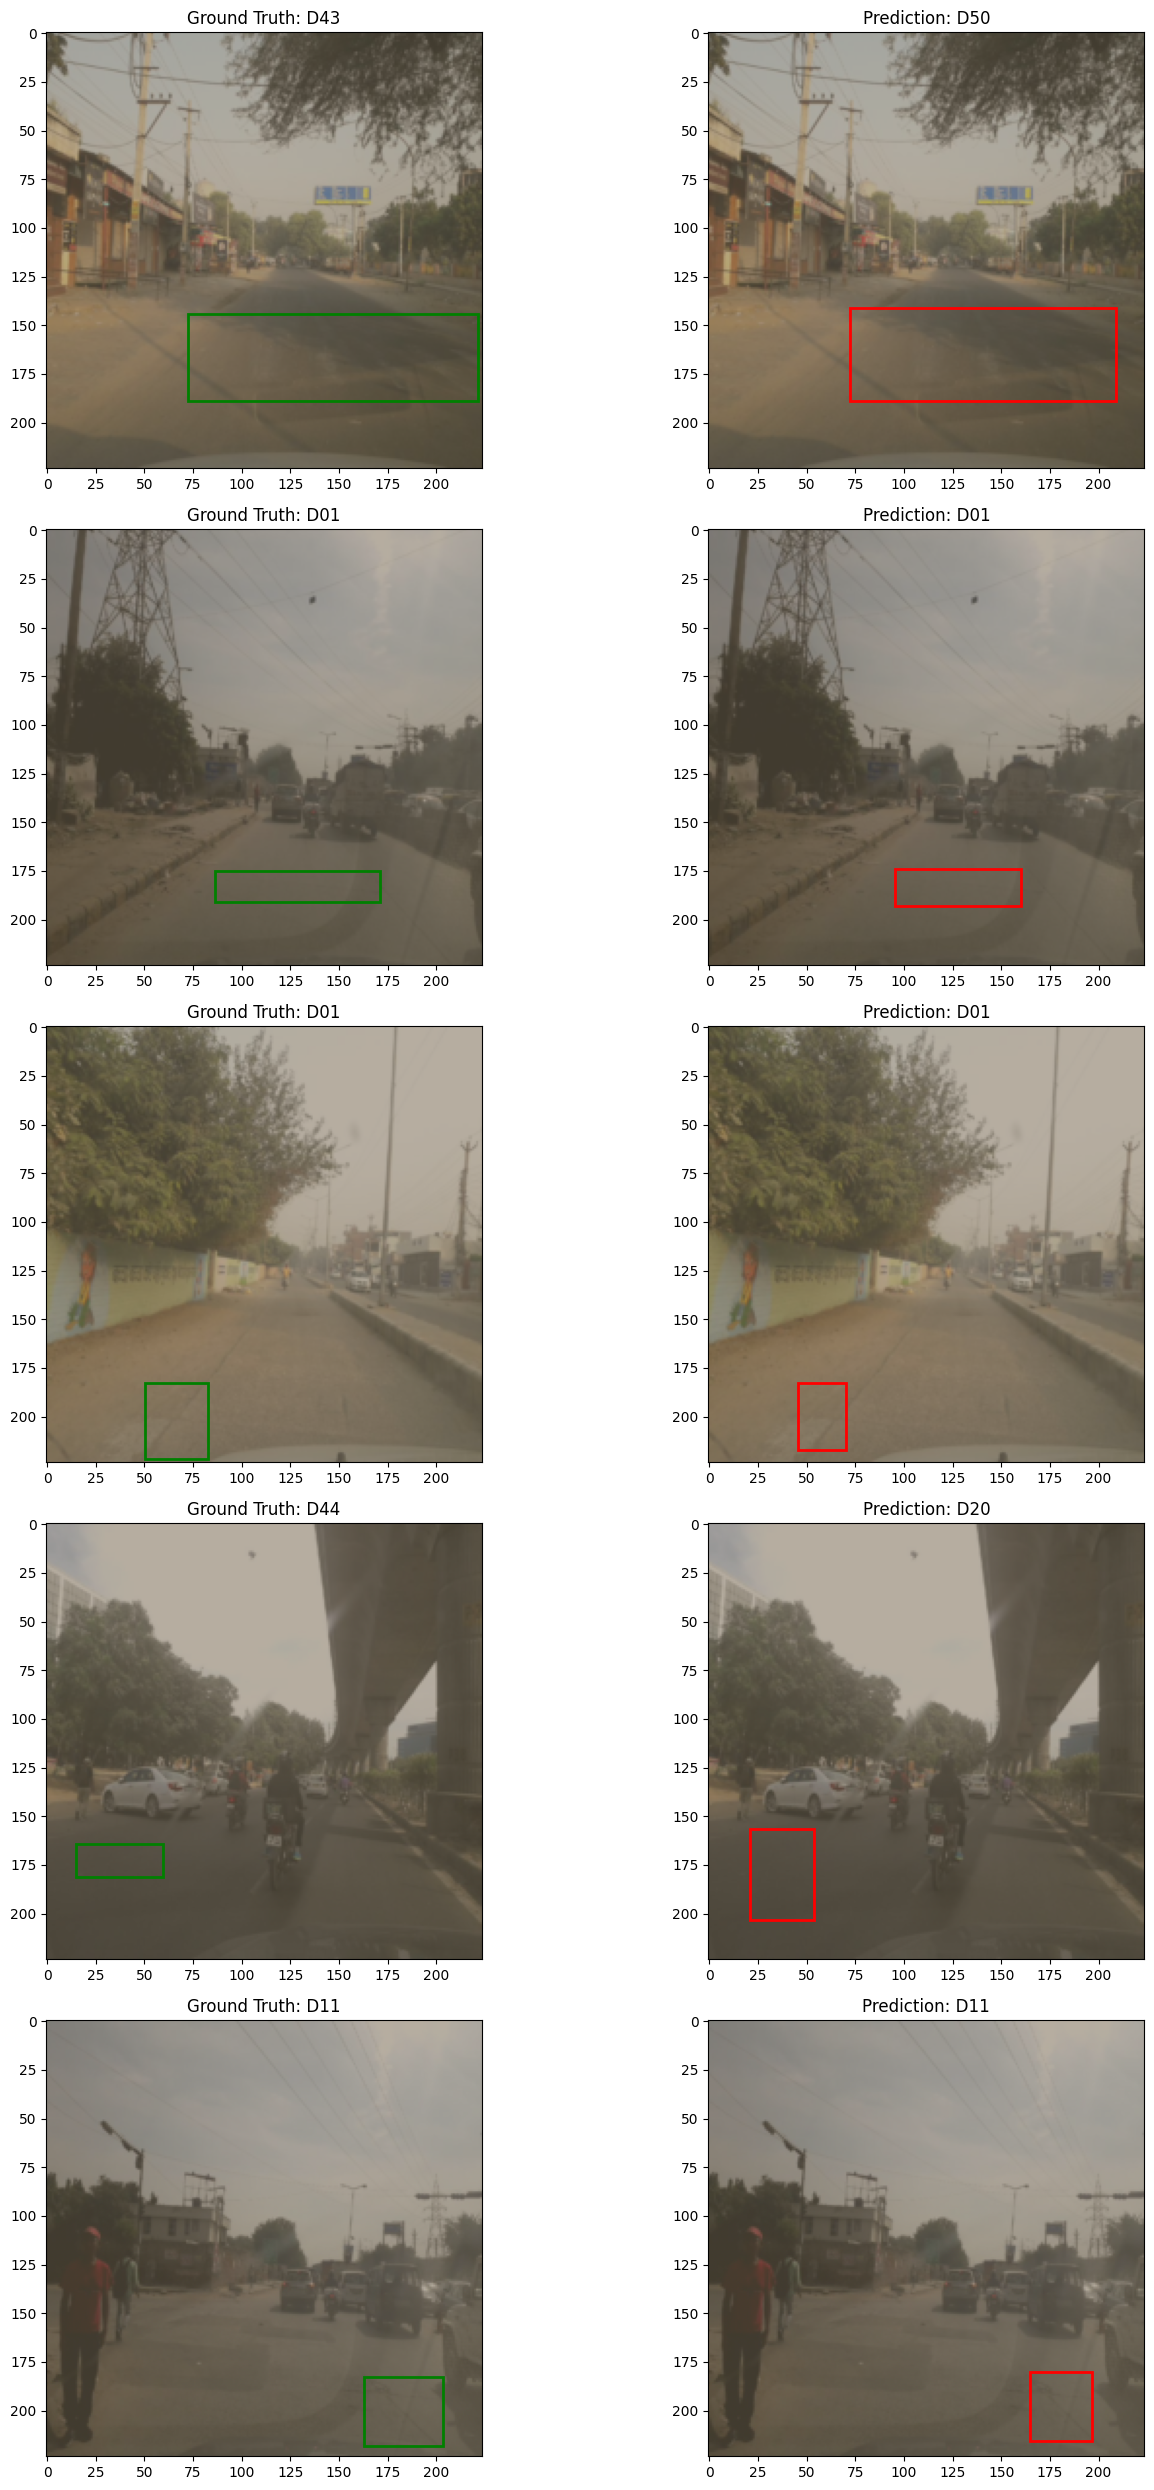

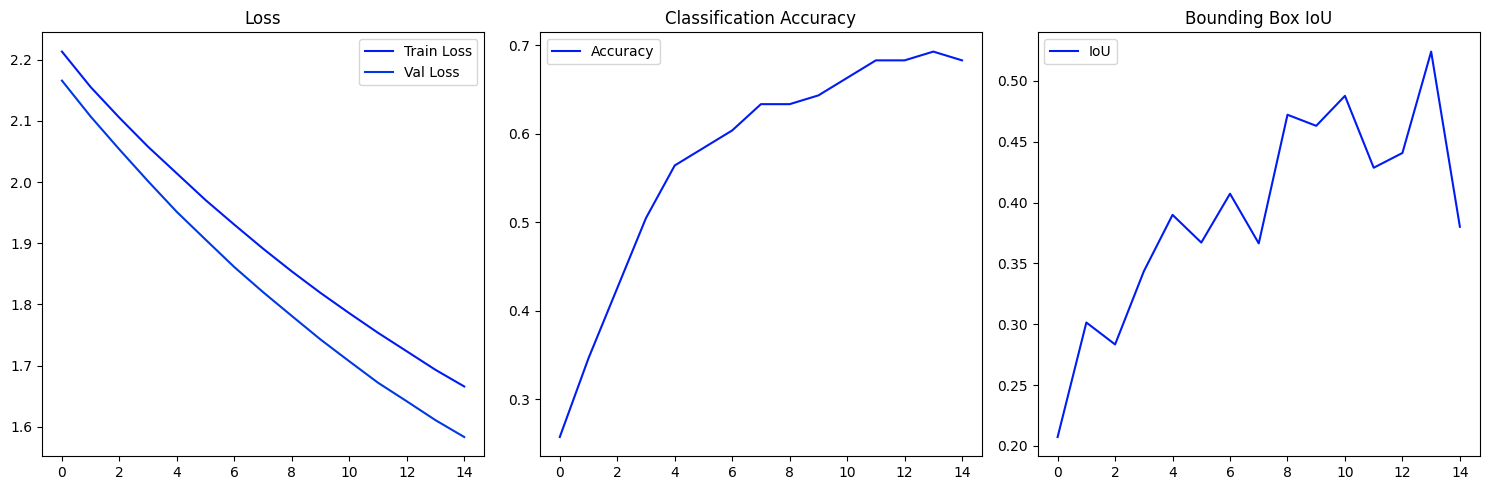

In [ ]:
if __name__ == "__main__":
    # Add Hugging Face token for authentication

    # Train the model
    model, history, feature_extractor = train_model(
        train_df, val_df, num_classes, label_encoder, num_epochs=15, hf_token=HF_TOKEN)

    # For inference
    def predict_damage(model, image_path, label_encoder, feature_extractor, device):
        model.eval()

        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        inputs = feature_extractor(images=image, return_tensors="pt")

        # Move to device
        for k, v in inputs.items():
            inputs[k] = v.to(device)

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)

        # Get class prediction
        pred_class_idx = torch.argmax(outputs['class_logits'], dim=1).item()
        pred_class = label_encoder.inverse_transform([pred_class_idx])[0]

        # Get bounding box prediction
        pred_box = outputs['bbox_pred'][0].cpu().numpy()

        # Display result
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.title(f"Predicted Damage: {pred_class}")

        # Draw predicted box
        width, height = image.size
        x1, y1, x2, y2 = pred_box
        rect = patches.Rectangle((x1 * width, y1 * height),
                                (x2 - x1) * width, (y2 - y1) * height,
                                linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.axis('off')
        plt.show()

        return pred_class, pred_box